## HW 3: Optimal Economic Dispatch in Distribution Feeders with Renewables
Talia Arauzo
3/19/21

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd

### Import Data

Node data

In [2]:
node_df = pd.read_excel("data/HW_Data.xls", sheet_name = 0, header = 2).drop([0, 14]).astype('float64')

Edge data

In [3]:
line_df = pd.read_excel("data/HW_Data.xls", sheet_name = 1)
# Resistance data
resistance_df = line_df.iloc[4:17, 1:14].reset_index(drop = True).astype('float64')
resistance_df.columns = resistance_df.index.values
# Reactance data
reactance_df = line_df.iloc[22:35, 1:14].reset_index(drop = True).astype('float64')
reactance_df.columns = reactance_df.index.values
# Max current data
max_current_df = line_df.iloc[40:53, 1:14].reset_index(drop = True).astype('float64')
max_current_df.columns = max_current_df.index.values

Set data

In [4]:
set_df = pd.read_excel("data/HW_Data.xls", sheet_name = 2, header = 1, usecols = [0, 1]).astype('float64')

### Test Feeder Parameters

Node data

In [56]:
# l_j^P: Active power consumption [MW]
l_P = node_df['l_j^P'].values

# l_j^Q: Reactive power consumption [MVAr]
l_Q = node_df['l_j^Q'].values

# l_j^S: Apparent power consumption [MVA]
l_S = np.sqrt(l_P**2 + l_Q**2)

# s_j,max: Maximal generating power [MW]
s_max = node_df['s_j,max'].values

# c_j: Marginal generation cost [USD/MW]
c = node_df['c_j'].values

# V_min, V_max: Minimum and maximum nodal voltages [V]
v_min = 0.95
v_max = 1.05

Edge Data

In [6]:
# r_ij: Resistance [p.u.]
r = resistance_df.to_numpy()

# x_ij: Reactance [p.u.]
x = reactance_df.to_numpy()

# I_max_ij: Maximal line current [p.u.]
I_max = max_current_df.to_numpy()

# A_ij: Adjacency matrix; A_ij = 1 if i is parent of j
A =  np.array([
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Set Data

In [7]:
# List of node indices
j_idx = np.arange(13)

# \rho(j): Parent node of node j
rho = set_df["rho(j)"].values

### Problem 1: Network Parameters

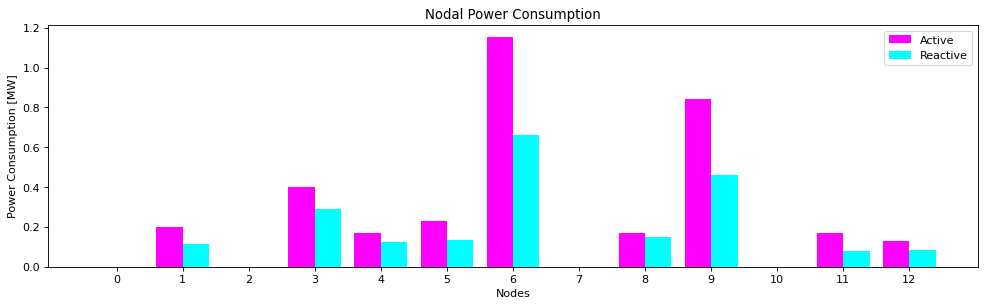

In [8]:
# Plot active and reactive power consumption
width = 0.4
fig, ax = plt.subplots(figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
ax.bar(j_idx - width/2, l_P, width, label='Active', color = 'magenta')
ax.bar(j_idx + width/2, l_Q, width, label='Reactive', color = 'cyan')
ax.set_xticks(j_idx)
ax.set_xlabel('Nodes')
ax.set_ylabel('Power Consumption [MW]')
ax.set_title('Nodal Power Consumption')
ax.legend()
plt.show();

### Problem 2: Balancing Supply & Demand without a Network

In [9]:
# Assumptions:
#   - Disregard the entire network diagram
#   - Relax apparent power generation equation into inequality
#   - Balance supply and demand, without any network considerations
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)

# Define objective function
objective = Minimize(c.T @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Balance power generation with power consumption
constraints += [sum(p) == sum(l_P)]
constraints += [sum(q) == sum(l_Q)]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation
    constraints += [p[jj] >= 0]
    constraints += [q[jj] >= 0]

    # Compute apparent power from active & reactive power
    constraints += [SOC(s[jj], vstack([p[jj], q[jj]]))]

# Define problem and solve
prob2 = Problem(objective, constraints)
prob2.solve()

# Output Results
print("------------------- PROBLEM 2 --------------------")
print("--------------------------------------------------")
print(prob2.status)
print("Minimum Generating Cost : %4.2f"%(prob2.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")

------------------- PROBLEM 2 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


### Problem 3: Add Line Power Flows

In [10]:
# Assumptions:
#   - Disregard L_ij, the squared magnitude of complex line current
#   - Disregard nodal voltage equation
#   - Disregard nodal voltage limits
#   - Disregard maximum line current
#   - Relax apparent power generation equation into inequality
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable((13, 13))
Q = Variable((13, 13))

# Define objective function
objective = Minimize(c.T @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Balance power generation with power consumption
constraints += [sum(p) == sum(l_P)]
constraints += [sum(q) == sum(l_Q)]

# Boundary condition for power line flows
constraints += [P[0,0] == 0, Q[0,0] == 0]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation and flows
    constraints += [p[jj] >= 0]
    constraints += [q[jj] >= 0]
    
    # Parent node, i = \rho(j)
    i = int(rho[jj])
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj] - p[jj]) + (A[jj,:] @ P[jj,:])]
    constraints += [Q[i,jj] == (l_Q[jj] - q[jj]) + (A[jj,:] @ Q[jj,:])]

    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(vstack([p[jj], q[jj]]))]

# Define problem and solve
prob3 = Problem(objective, constraints)
prob3.solve()

# Output Results
print("------------------- PROBLEM 3 --------------------")
print("--------------------------------------------------")
print(prob3.status)
print("Minimum Generating Cost : %4.2f"%(prob3.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")

------------------- PROBLEM 3 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 255.36 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.901 MW | q_0 = 0.546 MW | s_0 = 1.054 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 2.565 MW | q_9 = 1.556 MW | s_9 = 3.000 MW || mu_s9 =  50 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.054 MVA  generated


### Problem 4: Complete Optimal Economic Dispatch

In [57]:
# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current and apparent power generation equations into inequalities
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable((13, 13))
Q = Variable((13, 13))
V = Variable(13)
L = Variable((13, 13))

# Define objective function
objective = Minimize(c.T @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Nodal voltage limits
constraints += [V >= (v_min**2), V <= (v_max**2)]

# Squared line current limits
constraints += [L <= (I_max**2)]

# Boundary condition for power line flows
constraints += [P[0,0] == 0, Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation and flows
    constraints += [p[jj] >= 0]
    constraints += [q[jj] >= 0]
    
    # Parent node, i = \rho(j)
    i = int(rho[jj])
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj] - p[jj]) + (r[i,jj] * L[i,jj]) + (A[jj,:] @ P[jj,:])]
    constraints += [Q[i,jj] == (l_Q[jj] - q[jj]) + (x[i,jj] * L[i,jj]) + (A[jj,:] @ Q[jj,:])]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (((r[i,jj]**2) + (x[i,jj]**2))*L[i,jj]) - (2*((r[i,jj]*P[i,jj]) + (x[i,jj]*Q[i,jj])))]
    
    # Squared current magnitude on lines
    constraints += [L[i,jj] >= quad_over_lin(vstack([P[i,jj], Q[i,jj]]), V[jj])]
   
    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(vstack([p[jj], q[jj]]))]    

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print("------------------- PROBLEM 4 --------------------")
print("--------------------------------------------------")
print(prob4.status)
print("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")
print(" ")
for jj in j_idx:
    print("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 299.69 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.568 MW | q_0 = 0.985 MW | s_0 = 1.852 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.941 MW | q_9 = 1.216 MW | s_9 = 2.290 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.509 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.201 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.142 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.967 p.u.
Node  2 Voltage : 0.963 p.u.
Node  3 Voltage : 0.963 p.u.
Node  4 Voltage : 0.962 p.u.
Node  5 Voltage : 0.960 p.u.
Node  6 Voltage : 0.957 p.u.
Node  7 Voltage : 0.957 p.u.
Node  8 Voltage : 0.957 p.u.
Node  9 Voltage : 0.964 p.u.
Node 10 Voltage : 0.955 p.u.
Node 11 Voltage : 0.954 p.u.
Node 12

In [58]:
# Voltage constraint
vol_con = 1
vol_con_act = [(jj, constraints[vol_con].dual_value[jj]) for jj in j_idx if constraints[vol_con].dual_value[jj] > 0.0001]
print("active voltage constraints:", vol_con_act)

# Current constraint
cur_con = 3
cur_con_act = [((int(rho[jj]), jj), constraints[cur_con].dual_value[int(rho[jj]), jj]) for jj in j_idx if constraints[cur_con].dual_value[int(rho[jj]), jj] > 0.0001]
print("active current constraints:", cur_con_act)

active voltage constraints: []
active current constraints: [((0, 0), 140.2340489930906), ((8, 9), 22.518372443497622)]


In [25]:
# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current and apparent power generation equations into inequalities
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable((13, 13))
Q = Variable((13, 13))
V = Variable(13)
L = Variable((13, 13))

# Define objective function
objective = Minimize(c.T @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Nodal voltage limits
constraints += [V >= (v_min**2), V <= (v_max**2)]

# Squared line current limits
constraints += [L <= (I_max**2)]

# Boundary condition for power line flows
constraints += [P[0,0] == 0, Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation and flows
    constraints += [p[jj] >= 0]
    constraints += [q[jj] >= 0]
    
    # Parent node, i = \rho(j)
    i = int(rho[jj])
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj] - p[jj]) + (r[i,jj] * L[i,jj]) + (A[jj,:] @ P[jj,:])]
    constraints += [Q[i,jj] == (l_Q[jj] - q[jj]) + (x[i,jj] * L[i,jj]) + (A[jj,:] @ Q[jj,:])]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (((r[i,jj]**2) + (x[i,jj]**2))*L[i,jj]) - (2*((r[i,jj]*P[i,jj]) + (x[i,jj]*Q[i,jj])))]
    
    # Squared current magnitude on lines
    constraints += [L[i,jj] >= quad_over_lin(vstack([P[i,jj], Q[i,jj]]), V[jj])]
   
    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(vstack([p[jj], q[jj]]))]    

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print("------------------- PROBLEM 4 --------------------")
print("--------------------------------------------------")
print(prob4.status)
print("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")
print(" ")
for jj in j_idx:
    print("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 348.67 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.940 MW | q_0 = 0.174 MW | s_0 = 0.956 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.760 MW | q_3 = 0.518 MW | s_3 = 0.920 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.789 MW | q_9 = 1.450 MW | s_9 = 2.303 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.489 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.142 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.178 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.989 p.u.
Node  2 Voltage : 0.992 p.u.
Node  3 Voltage : 0.992 p.u.
Node  4 Voltage : 0.984 p.u.
Node  5 Voltage : 0.983 p.u.
Node  6 Voltage : 0.984 p.u.
Node  7 Voltage : 0.984 p.u.
Node  8 Voltage : 0.984 p.u.
Node  9 Voltage : 0.991 p.u.
Node 10 Voltage : 0.982 p.u.
Node 11 Voltage : 0.981 p.u.
Node 12

### Problem 5: Robust Economic Dispatch with Renewables

In [61]:
# Assumptions:
#   - Assume solar generator at node 9 has uncertain power capacity
#   - Goal is to minimize generation costs, given by c^T s, in face of uncertainty

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)
P = Variable((13, 13))
Q = Variable((13, 13))
V = Variable(13)
L = Variable((13, 13))
sig = Variable(2)

# Define objective function
objective = Minimize(c.T @ s)

# Define constraints
# Apparent Power Limits
constraints = [s <= s_max]

# Nodal voltage limits
constraints += [V >= (v_min**2), V <= (v_max**2)]

# Squared line current limits
constraints += [L <= (I_max**2)]

# Solar panels percentage output
constraints += [sig >= 0, sig <= 1]

# Boundary condition for power line flows
constraints += [P[0,0] == 0, Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation and flows
    constraints += [p[jj] >= 0]
    constraints += [q[jj] >= 0]
    
    # Parent node, i = \rho(j)
    i = int(rho[jj])
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj] - p[jj]) + (r[i,jj] * L[i,jj]) + (A[jj,:] @ P[jj,:])]
    constraints += [Q[i,jj] == (l_Q[jj] - q[jj]) + (x[i,jj] * L[i,jj]) + (A[jj,:] @ Q[jj,:])]

    # Nodal voltage
    constraints += [V[jj] == V[i] + (((r[i,jj]**2) + (x[i,jj]**2))*L[i,jj]) - (2*((r[i,jj]*P[i,jj]) + (x[i,jj]*Q[i,jj])))]
    
    # Squared current magnitude on lines
    constraints += [L[i,jj] >= quad_over_lin(vstack([P[i,jj], Q[i,jj]]), V[jj])]
   
    # Compute apparent power from active & reactive power
    constraints += [s[jj] >= norm(vstack([p[jj], q[jj]]))]    

# Solar panel constraints
a_bar = np.array([-1.25, -1.25, 1])
E = np.diag([0.25, 0.25, 0])
y = vstack((sig[0], sig[1], s[9]))
b = 0
constraints += [a_bar.T@y + norm(E.T@y) <= 0]
    
# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print("------------------- PROBLEM 5 --------------------")
print("--------------------------------------------------")
print(prob4.status)
print("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print(" ")
print("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print(" ")
print("Total active power   : %1.3f"%(np.sum(l_P)),"MW   consumed | %1.3f"%(np.sum(p.value)),"MW   generated")
print("Total reactive power : %1.3f"%(np.sum(l_Q)),"MVAr consumed | %1.3f"%(np.sum(q.value)),"MVAr generated")
print("Total apparent power : %1.3f"%(np.sum(l_S)),"MVA  consumed | %1.3f"%(np.sum(s.value)),"MVA  generated")
print(" ")
for jj in j_idx:
    print("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")

------------------- PROBLEM 5 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 308.72 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.745 MW | q_0 = 1.006 MW | s_0 = 2.014 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = 0.000 MW | s_3 = -0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.770 MW | q_9 = 1.215 MW | s_9 = 2.146 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.514 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.221 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.160 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.965 p.u.
Node  2 Voltage : 0.961 p.u.
Node  3 Voltage : 0.961 p.u.
Node  4 Voltage : 0.960 p.u.
Node  5 Voltage : 0.958 p.u.
Node  6 Voltage : 0.954 p.u.
Node  7 Voltage : 0.954 p.u.
Node  8 Voltage : 0.954 p.u.
Node  9 Voltage : 0.960 p.u.
Node 10 Voltage : 0.952 p.u.
Node 11 Voltage : 0.951 p.u.
Node 1